# Connection

## Libraries, data acquisition and onehot encoding 

In [1]:
from copyreg import pickle
import snowflake.connector
import logging
from os import environ
from dotenv import load_dotenv
import os
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
import optuna
from statistics import mean
import joblib

# Connection to snowflake

In [3]:
# Ativar mensagens de depuração
load_dotenv()
for logger_name in ['snowflake.connector', 'botocore']:
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    logger.addHandler(handler)

conn = snowflake.connector.connect(
    user = environ['USER'],
    password = environ['PASSWORD'],
    account = environ['ACCOUNT'],
    warehouse = environ['WAREHOUSE'],
    database = environ['DATABASE'],
    schema = environ['SCHEMA']
)

Snowflake Connector for Python Version: 3.12.2, Python Version: 3.10.14, Platform: Windows-10-10.0.22631-SP0
connect
__config
Connecting to GLOBAL Snowflake domain
This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
use_numpy: False
initialized
REST API object was created: fa62087.us-east-2.aws.snowflakecomputing.com:443
authenticate
assertion content: *********
account=fa62087, user=PAULO_MAIA, database=POKER_PROD, schema=POKER, warehouse=REPORTING_POKER_WH, role=None, request_id=359178cf-b172-4cca-9420-aaa6ec6706d2
body['data']: {'CLIENT_APP_ID': 'PythonConnector', 'CLIENT_APP_VERSION': '3.12.2', 'SVN_REVISION': None, 'ACCOUNT_NAME': 'fa62087', 'LOGIN_NAME': 'PAULO_MAIA', 'CLIENT_ENVIRONMENT': {'APPLICATION': 'PythonConnector', 'OS': 'Windows', 'OS_VERSION': 'Windows-10-10.0.22631-SP0', 'PYTHON_VERSI

# Query

In [4]:
query = '''
select
    match_id,
    start_hour_local, day_of_week_local, ko_type,
    mtt_pool_allocation_description,
    cast(level_reject as integer) as level_reject, 
    estrutura_blinds, time_blind_match_mtt,
    earlybird, has_rebuy, has_addon,
    mtt_customer_buy_in, mtt_customer_rebuy, 
    mtt_customer_addon, gtd, has_overlay,
    overlay, mtt_result, collected,
    normalized_mtt_result as normalized_result,
    normalized_collected, 
    (gtd/mtt_customer_buy_in) as Buyin_Gtd_rate
from 
    bi_mtt_overlay
where
    match_type_detail_name = 'MTT-NLH'
    and class_match in ('Micro', 'Low')
    and gtd between 30 and 58000
    and buyin_gtd_rate between 33 and 7833
    and start_date_local <= '2024-10-19'
    and class_match in ('Micro', 'Low')
'''

In [35]:
query = '''
select
    match_id,
    start_hour_local, day_of_week_local, ko_type,
    mtt_pool_allocation_description,
    estrutura_blinds, time_blind_match_mtt,
    earlybird, has_rebuy, has_addon,
    mtt_customer_buy_in, mtt_customer_rebuy, 
    mtt_customer_addon, gtd, has_overlay,
    overlay, mtt_result, collected,
    (mtt_result/mtt_customer_buy_in) as normalized_result,
    (collected/mtt_customer_buy_in) as normalized_collected, 
    (gtd/mtt_customer_buy_in) as Buyin_Gtd_rate
from 
    bi_mtt_overlay
where
    match_type_detail_name = 'MTT-NLH'
    and mtt_customer_buy_in > 0
'''

In [5]:
data = pd.read_sql_query(query, conn)

C:\Users\maiap\AppData\Local\Temp\ipykernel_37048\3998575330.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, conn)
cursor
executing SQL/command
query: [select match_id, start_hour_local, day_of_week_local, ko_type, mtt_pool_allocati...]
binding: [select match_id, start_hour_local, day_of_week_local, ko_type, mtt_pool_allocati...] with input=[None], processed=[{}]
sequence counter: 1
Request id: f092f601-060c-431a-b7ea-741ca767ad42
running query [select match_id, start_hour_local, day_of_week_local, ko_type, mtt_pool_allocati...]
is_file_transfer: True
_cmd_query
serialize_to_dict() called
sql=[select match_id, start_hour_local, day_of_week_local, ko_type, mtt_pool_allocati...], sequence_id=[1], is_file_transfer=[False]
Opentelemtry otel injection failed because of: No module named 'opentelemetry'

In [6]:
data

,MATCH_ID,START_HOUR_LOCAL,DAY_OF_WEEK_LOCAL,KO_TYPE,MTT_POOL_ALLOCATION_DESCRIPTION,LEVEL_REJECT,ESTRUTURA_BLINDS,TIME_BLIND_MATCH_MTT,EARLYBIRD,HAS_REBUY,...,MTT_CUSTOMER_REBUY,MTT_CUSTOMER_ADDON,GTD,HAS_OVERLAY,OVERLAY,MTT_RESULT,COLLECTED,NORMALIZED_RESULT,NORMALIZED_COLLECTED,BUYIN_GTD_RATE
0,21922340,15,Sábado,None,15% Flat,15,Hyper,10.0,0.2,True,...,3.0,3.0,4000,False,0.00,123.68,4123.68,41.226667,1374.560000,1333.333333
1,21922354,17,Sábado,Progressive KO,15% Flat,15,Hyper,12.0,0.2,True,...,11.0,0.0,8000,True,-507.68,-507.68,7492.32,-46.152727,681.120000,727.272727
2,21922422,18,Sábado,None,15% Flat,15,Hyper,12.0,0.2,True,...,3.0,3.0,6000,False,0.00,1207.20,7207.20,402.400000,2402.400000,2000.000000
3,21923762,6,Sábado,None,20% Flat,12,Hyper,5.0,0.2,True,...,1.0,1.0,120,False,0.00,68.10,188.10,68.100000,188.100000,120.000000
4,21923899,7,Sábado,KO,15% Flat,13,Turbo,8.0,0.2,True,...,1.0,0.0,80,False,0.00,46.00,126.00,46.000000,126.000000,80.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14337,26195449,11,Sábado,None,15% Flat,15,Turbo,10.0,0.2,True,...,3.0,3.0,2000,False,0.00,993.76,2993.76,331.253333,997.920000,666.666667
14338,26196177,12,Sábado,None,15% Flat,15,Turbo,6.0,0.2,True,...,0.6,0.6,300,False,0.00,127.15,427.15,211.916667,711.916667,500.000000
14339,26196243,12,Sábado,KO,15% Flat,13,Turbo,8.0,0.2,True,...,1.0,0.0,80,False,0.00,37.04,117.04,37.040000,117.040000,80.000000
14340,26196327,13,Sábado,KO,15% Flat,14,Hyper,10.0,0.2,True,...,5.0,0.0,2000,False,0.00,318.80,2318.80,63.760000,463.760000,400.000000


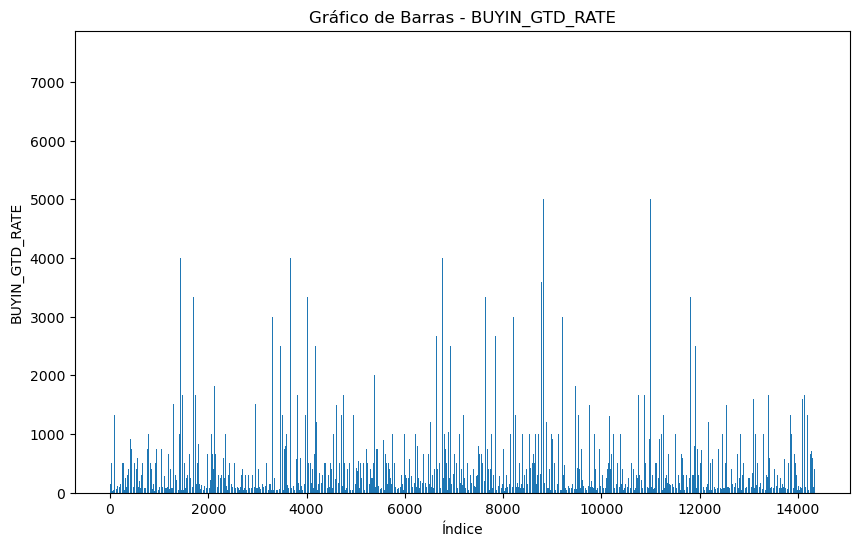

In [7]:
# Criando o gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(data.index, data['BUYIN_GTD_RATE'])
plt.xlabel('Índice')
plt.ylabel('BUYIN_GTD_RATE')
plt.title('Gráfico de Barras - BUYIN_GTD_RATE')
plt.show()

In [95]:
data.columns

Index(['MATCH_ID', 'START_HOUR_LOCAL', 'DAY_OF_WEEK_LOCAL', 'KO_TYPE',
       'MTT_POOL_ALLOCATION_DESCRIPTION', 'LEVEL_REJECT', 'ESTRUTURA_BLINDS',
       'TIME_BLIND_MATCH_MTT', 'EARLYBIRD', 'HAS_REBUY', 'HAS_ADDON',
       'MTT_CUSTOMER_BUY_IN', 'MTT_CUSTOMER_REBUY', 'MTT_CUSTOMER_ADDON',
       'GTD', 'HAS_OVERLAY', 'OVERLAY', 'MTT_RESULT', 'COLLECTED',
       'NORMALIZED_RESULT', 'NORMALIZED_COLLECTED', 'BUYIN_GTD_RATE'],
      dtype='object')

In [8]:
encoder = OneHotEncoder(sparse_output=False)
data_transform = data.drop(columns=['MATCH_ID'])
cat_columns = ['START_HOUR_LOCAL', 'DAY_OF_WEEK_LOCAL', 'KO_TYPE', 
               'MTT_POOL_ALLOCATION_DESCRIPTION', 'ESTRUTURA_BLINDS']
encoded_columns = encoder.fit_transform(data_transform[cat_columns])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(cat_columns))
data_final = pd.concat([data_transform.drop(cat_columns, axis=1), encoded_df], axis=1)
data_final

,LEVEL_REJECT,TIME_BLIND_MATCH_MTT,EARLYBIRD,HAS_REBUY,HAS_ADDON,MTT_CUSTOMER_BUY_IN,MTT_CUSTOMER_REBUY,MTT_CUSTOMER_ADDON,GTD,HAS_OVERLAY,...,MTT_POOL_ALLOCATION_DESCRIPTION_10% Plus,MTT_POOL_ALLOCATION_DESCRIPTION_15%,MTT_POOL_ALLOCATION_DESCRIPTION_15% Flat,MTT_POOL_ALLOCATION_DESCRIPTION_20%,MTT_POOL_ALLOCATION_DESCRIPTION_20% Flat,ESTRUTURA_BLINDS_Hyper,ESTRUTURA_BLINDS_Hyper - no ante,ESTRUTURA_BLINDS_Standard - no ante,ESTRUTURA_BLINDS_Turbo,ESTRUTURA_BLINDS_Turbo - no ante
0,15,10.0,0.2,True,True,3.0,3.0,3.0,4000,False,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,15,12.0,0.2,True,False,11.0,11.0,0.0,8000,True,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,15,12.0,0.2,True,True,3.0,3.0,3.0,6000,False,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,12,5.0,0.2,True,True,1.0,1.0,1.0,120,False,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,13,8.0,0.2,True,False,1.0,1.0,0.0,80,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14337,15,10.0,0.2,True,True,3.0,3.0,3.0,2000,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14338,15,6.0,0.2,True,True,0.6,0.6,0.6,300,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14339,13,8.0,0.2,True,False,1.0,1.0,0.0,80,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14340,14,10.0,0.2,True,False,5.0,5.0,0.0,2000,False,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
data_final.columns

Index(['LEVEL_REJECT', 'TIME_BLIND_MATCH_MTT', 'EARLYBIRD', 'HAS_REBUY',
       'HAS_ADDON', 'MTT_CUSTOMER_BUY_IN', 'MTT_CUSTOMER_REBUY',
       'MTT_CUSTOMER_ADDON', 'GTD', 'HAS_OVERLAY', 'OVERLAY', 'MTT_RESULT',
       'COLLECTED', 'NORMALIZED_RESULT', 'NORMALIZED_COLLECTED',
       'BUYIN_GTD_RATE', 'START_HOUR_LOCAL_0', 'START_HOUR_LOCAL_1',
       'START_HOUR_LOCAL_2', 'START_HOUR_LOCAL_3', 'START_HOUR_LOCAL_4',
       'START_HOUR_LOCAL_5', 'START_HOUR_LOCAL_6', 'START_HOUR_LOCAL_7',
       'START_HOUR_LOCAL_8', 'START_HOUR_LOCAL_9', 'START_HOUR_LOCAL_10',
       'START_HOUR_LOCAL_11', 'START_HOUR_LOCAL_12', 'START_HOUR_LOCAL_13',
       'START_HOUR_LOCAL_14', 'START_HOUR_LOCAL_15', 'START_HOUR_LOCAL_16',
       'START_HOUR_LOCAL_17', 'START_HOUR_LOCAL_18', 'START_HOUR_LOCAL_19',
       'START_HOUR_LOCAL_20', 'START_HOUR_LOCAL_21', 'START_HOUR_LOCAL_22',
       'START_HOUR_LOCAL_23', 'DAY_OF_WEEK_LOCAL_Domingo',
       'DAY_OF_WEEK_LOCAL_Quarta', 'DAY_OF_WEEK_LOCAL_Quinta',
      

In [10]:
X = data_final.drop(columns=['HAS_OVERLAY', 'OVERLAY', 'MTT_RESULT', 'COLLECTED', 'NORMALIZED_RESULT', 'NORMALIZED_COLLECTED' ], axis=1)
y = data_final['COLLECTED']
X.columns

Index(['LEVEL_REJECT', 'TIME_BLIND_MATCH_MTT', 'EARLYBIRD', 'HAS_REBUY',
       'HAS_ADDON', 'MTT_CUSTOMER_BUY_IN', 'MTT_CUSTOMER_REBUY',
       'MTT_CUSTOMER_ADDON', 'GTD', 'BUYIN_GTD_RATE', 'START_HOUR_LOCAL_0',
       'START_HOUR_LOCAL_1', 'START_HOUR_LOCAL_2', 'START_HOUR_LOCAL_3',
       'START_HOUR_LOCAL_4', 'START_HOUR_LOCAL_5', 'START_HOUR_LOCAL_6',
       'START_HOUR_LOCAL_7', 'START_HOUR_LOCAL_8', 'START_HOUR_LOCAL_9',
       'START_HOUR_LOCAL_10', 'START_HOUR_LOCAL_11', 'START_HOUR_LOCAL_12',
       'START_HOUR_LOCAL_13', 'START_HOUR_LOCAL_14', 'START_HOUR_LOCAL_15',
       'START_HOUR_LOCAL_16', 'START_HOUR_LOCAL_17', 'START_HOUR_LOCAL_18',
       'START_HOUR_LOCAL_19', 'START_HOUR_LOCAL_20', 'START_HOUR_LOCAL_21',
       'START_HOUR_LOCAL_22', 'START_HOUR_LOCAL_23',
       'DAY_OF_WEEK_LOCAL_Domingo', 'DAY_OF_WEEK_LOCAL_Quarta',
       'DAY_OF_WEEK_LOCAL_Quinta', 'DAY_OF_WEEK_LOCAL_Segunda',
       'DAY_OF_WEEK_LOCAL_Sexta', 'DAY_OF_WEEK_LOCAL_Sábado',
       'DAY_OF_WEEK_

In [12]:
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import pandas as pd

def cross_validation_optuna(trial, X, y, n_splits):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.8)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Define the model with updated device parameter
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        device='cuda',  # Use GPU acceleration
        random_state=42
    )

    kfold = KFold(n_splits=n_splits)
    mse_scores_split_lst = []
    all_pred = []
    all_reals = []

    for idx, (idx_train, idx_test) in enumerate(kfold.split(X)):
        X_split_train = X.iloc[idx_train, :]
        y_split_train = y.iloc[idx_train]

        # For regression, no need for SMOTE
        model.fit(X_split_train, y_split_train)

        X_split_test = X.iloc[idx_test, :]
        y_split_test = y.iloc[idx_test]

        predt_validation = model.predict(X_split_test)

        mse_split = mean_squared_error(y_split_test, predt_validation)
        mse_scores_split_lst.append(mse_split)

        all_pred.extend(predt_validation)
        all_reals.extend(y_split_test.values.flatten())

        print(f'Mean Squared Error on split {idx}: {mse_split}')

    # Compute overall metrics
    overall_mse = mean(mse_scores_split_lst)
    overall_r2 = r2_score(all_reals, all_pred)
    print(f'\nOverall Mean Squared Error: {overall_mse}')
    print(f'Overall R^2 Score: {overall_r2}')

    importance = model.feature_importances_
    importances = pd.Series(importance, index=X.columns)

    return overall_mse, model, importances

def optimize_hyperparameters(X, y):
    study = optuna.create_study(direction='minimize')

    def objective(trial):
        mse_mean, model, importances = cross_validation_optuna(trial, X, y, n_splits=10)
        trial.set_user_attr("model", model)
        trial.set_user_attr("importances", importances)
        return mse_mean

    study.optimize(objective, n_trials=40)

    # Show the best parameters
    print("Best hyperparameters: ", study.best_params)
    print("Best score (MSE): ", study.best_value)

    # Retrieve the best model and feature importances
    best_trial = study.best_trial
    best_model = best_trial.user_attrs["model"]
    best_importances = best_trial.user_attrs["importances"]

    return study.best_params


In [ ]:
bestparam = optimize_hyperparameters(X, y)

In [11]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Defining the cross-validation function for XGBoost regressor with Optuna
def cross_validation_optuna(trial, X, y, n_splits):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.8)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1e1, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1e1, log=True)


    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma = gamma,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        device='cuda',
        random_state=42
    )

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results_list = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Create a DataFrame to store all relevant metrics
        results_df = pd.DataFrame({
            'Realizado': y_test,
            'Previsto': predictions,
        })

        # Calculate the additional metrics
        results_df['Diferença Absoluta'] = np.abs(results_df['Realizado'] - results_df['Previsto'])
        results_df['Diferença Quadrática'] = (results_df['Realizado'] - results_df['Previsto']) ** 2
        results_df['Erro %'] = (results_df['Realizado'] - results_df['Previsto']) / results_df['Realizado'] * 100
        results_df['Erro Absoluto %'] = np.abs(results_df['Erro %'])

        # Append to the results list
        results_list.append(results_df)

    # Concatenate the results from all splits
    full_results_df = pd.concat(results_list, ignore_index=True)

    return full_results_df, model

# Defining the optimization function for hyperparameter tuning
def optimize_hyperparameters(X, y):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    def objective(trial):
        full_results_df, model = cross_validation_optuna(trial, X, y, n_splits=10)
        trial.set_user_attr("model", model)
        trial.set_user_attr("results", full_results_df)
        return full_results_df['Diferença Absoluta'].median()  # Using MSE as the optimization target

    study.optimize(objective, n_trials=100)

    # Show the best parameters
    print("Best hyperparameters: ", study.best_params)

    # Retrieve the best model and the detailed results
    best_trial = study.best_trial
    best_model = best_trial.user_attrs["model"]
    best_results = best_trial.user_attrs["results"]

    return best_model, best_results


best_model, best_results_df = optimize_hyperparameters(X, y)


[I 2024-10-21 10:22:25,744] A new study created in memory with name: no-name-bd36eb63-abb5-43c6-8c08-6c4528778724
C:\Users\maiap\anaconda3\envs\suprema-env\lib\site-packages\xgboost\core.py:158: UserWarning: [10:22:27] WARNING: D:\bld\xgboost-split_1727635012356\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-10-21 10:22:34,576] Trial 0 finished with value: 35.63596435546873 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.7516113013907249, 'subsample': 0.733570369576339, 'colsample_bytree': 0.6543022304705693, 'gamma': 0.22994831073413047, 'min_child_w

Best hyperparameters:  {'n_estimators': 73, 'max_depth': 18, 'learning_rate': 0.21749803234285686, 'subsample': 0.7203435518090132, 'colsample_bytree': 0.8131524681503086, 'gamma': 2.6680641428348593, 'min_child_weight': 8, 'reg_alpha': 0.21342641554211036, 'reg_lambda': 3.3888187739995197}


### teste com meno parametros, 40 trials e 10 splits:
[I 2024-10-16 10:32:19,658] Trial 24 finished with value: 55.34459093761555 and parameters: {'n_estimators': 160, 'max_depth': 7, 'learning_rate': 0.1508486457172113, 'subsample': 0.6867963009293934, 'colsample_bytree': 0.6995963546862939}. Best is trial 24 with value: 55.34459093761555.
### teste com mais parametros, 100 trials e 10 splits
Best hyperparameters:  {'n_estimators': 121, 'max_depth': 16, 'learning_rate': 0.10620607112992911, 'subsample': 0.930153327574823, 'colsample_bytree': 0.6745557124089456, 'gamma': 2.2130653804044575, 'min_child_weight': 10, 'reg_alpha': 1.7797678659251623, 'reg_lambda': 7.545343105606722} 
Best is trial 79 with value: 55.25160905535815


In [148]:
'''import pickle
with open('micro_low/encoder.pkl', 'wb') as arquivo:
    pickle.dump(encoder, arquivo)'''

In [12]:
best_results_df

,Realizado,Previsto,Diferença Absoluta,Diferença Quadrática,Erro %,Erro Absoluto %
0,766.80,662.930908,103.869092,10788.788231,13.545787,13.545787
1,140.40,115.184448,25.215552,635.824050,17.959795,17.959795
2,1099.30,1147.276001,47.976001,2301.696670,-4.364232,4.364232
3,1154.56,1008.013977,146.546023,21475.736842,12.692803,12.692803
4,1135.20,1208.915527,73.715527,5433.978972,-6.493616,6.493616
...,...,...,...,...,...,...
14337,188.32,232.026733,43.706733,1910.278544,-23.208758,23.208758
14338,1201.20,1034.928833,166.271167,27646.100973,13.842088,13.842088
14339,487.52,336.439697,151.080303,22825.257874,30.989560,30.989560
14340,621.00,670.227661,49.227661,2423.362621,-7.927160,7.927160


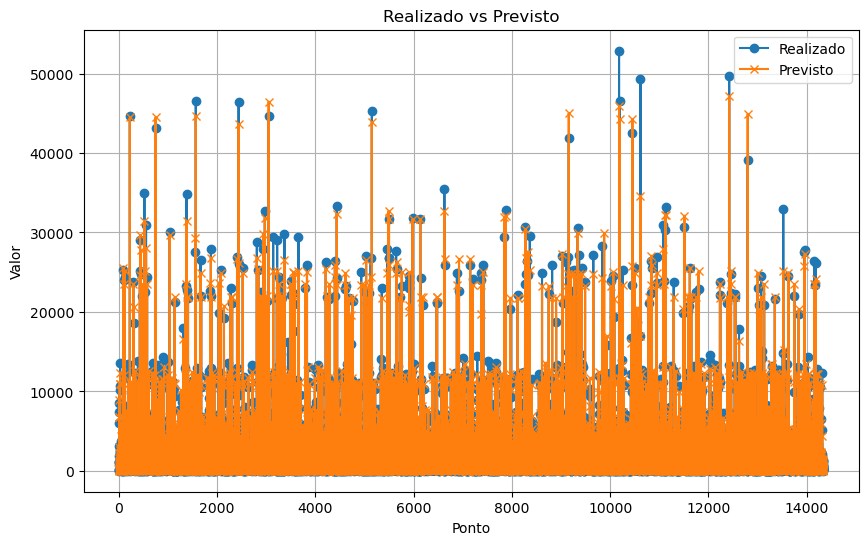

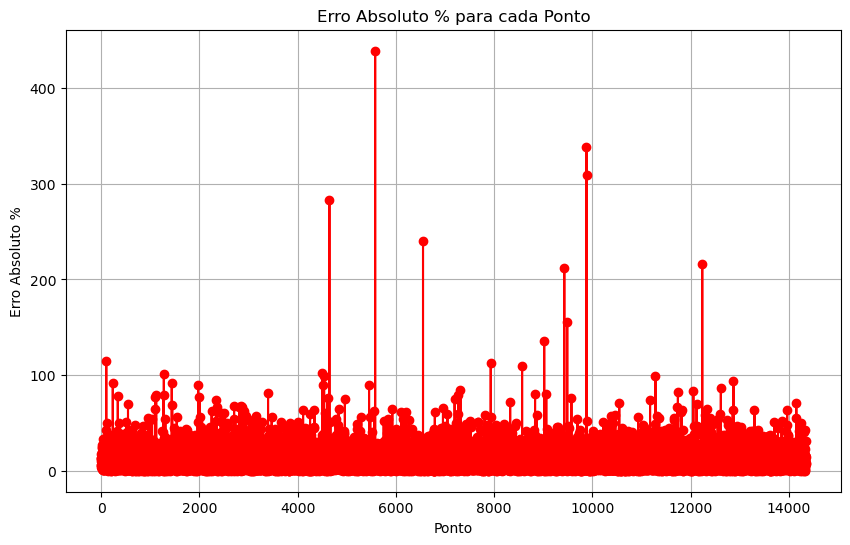

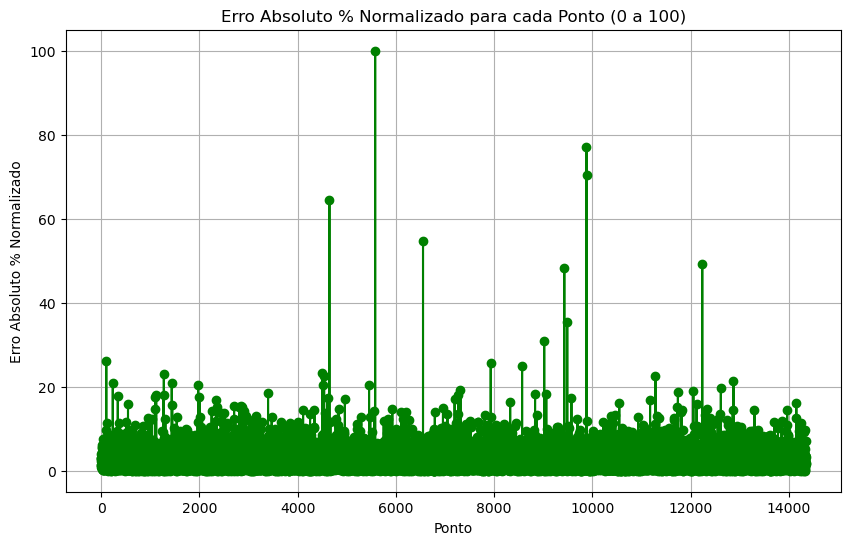

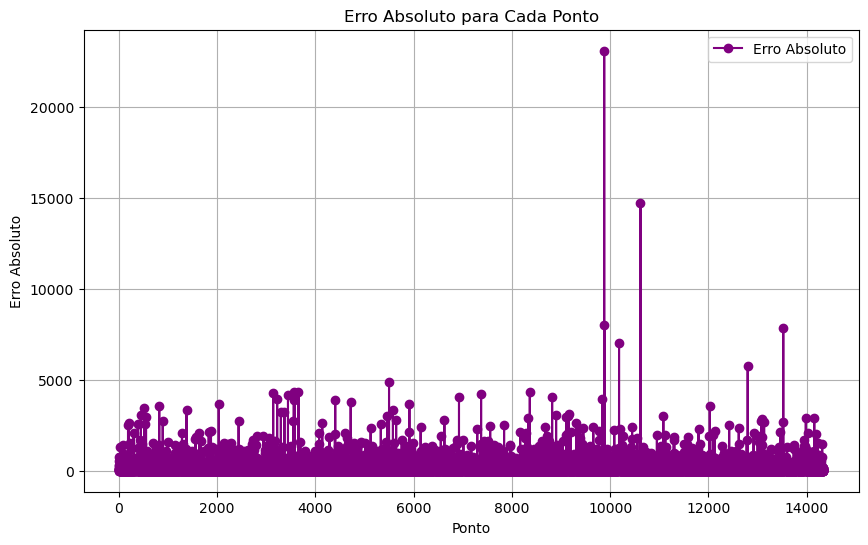

A media do erro absoluto por ponto seria de:139.51946898018193
A mediana do erro absoluto por ponto seria de:34.66366455078125


(2.5021900738260276, 1.888335045985896)

In [14]:
# Extracting the necessary columns for plotting
realizado = best_results_df['Realizado']
previsto = best_results_df['Previsto']
erro_absoluto = best_results_df['Erro Absoluto %']

# Plot 1: Realizado vs Previsto
plt.figure(figsize=(10,6))
plt.plot(realizado, label='Realizado', marker='o')
plt.plot(previsto, label='Previsto', marker='x')
plt.title('Realizado vs Previsto')
plt.xlabel('Ponto')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Erro Absoluto % para cada ponto
plt.figure(figsize=(10,6))
plt.plot(erro_absoluto, label='Erro Absoluto %', color='red', marker='o')
plt.title('Erro Absoluto % para cada Ponto')
plt.xlabel('Ponto')
plt.ylabel('Erro Absoluto %')
plt.grid(True)
plt.show()

# Normalizando o Erro Absoluto % de 0 a 100
erro_absoluto_normalizado = 100 * (erro_absoluto - erro_absoluto.min()) / (erro_absoluto.max() - erro_absoluto.min())

# Plot 3: Erro Absoluto % Normalizado
plt.figure(figsize=(10,6))
plt.plot(erro_absoluto_normalizado, label='Erro Absoluto % Normalizado', color='green', marker='o')
plt.title('Erro Absoluto % Normalizado para cada Ponto (0 a 100)')
plt.xlabel('Ponto')
plt.ylabel('Erro Absoluto % Normalizado')
plt.grid(True)
plt.show()

# Calculando o erro absoluto para cada ponto
erro_absoluto_por_ponto = np.abs(realizado - previsto)

# Plotando o erro absoluto para cada ponto
plt.figure(figsize=(10,6))
plt.plot(erro_absoluto_por_ponto, label='Erro Absoluto', color='purple', marker='o')
plt.title('Erro Absoluto para Cada Ponto')
plt.xlabel('Ponto')
plt.ylabel('Erro Absoluto')
plt.grid(True)
plt.legend()
plt.show()


# Cálculo da média e mediana do erro absoluto normalizado
print(f'A media do erro absoluto por ponto seria de:{erro_absoluto_por_ponto.mean()}')
print(f'A mediana do erro absoluto por ponto seria de:{erro_absoluto_por_ponto.median()}')
media_erro_normalizado = np.mean(erro_absoluto_normalizado)
mediana_erro_normalizado = np.median(erro_absoluto_normalizado)

media_erro_normalizado, mediana_erro_normalizado


In [126]:
X

,LEVEL_REJECT,TIME_BLIND_MATCH_MTT,EARLYBIRD,HAS_REBUY,HAS_ADDON,MTT_CUSTOMER_BUY_IN,MTT_CUSTOMER_REBUY,MTT_CUSTOMER_ADDON,GTD,BUYIN_GTD_RATE,...,MTT_POOL_ALLOCATION_DESCRIPTION_15%,MTT_POOL_ALLOCATION_DESCRIPTION_15% Flat,MTT_POOL_ALLOCATION_DESCRIPTION_20%,MTT_POOL_ALLOCATION_DESCRIPTION_20% Flat,ESTRUTURA_BLINDS_3,ESTRUTURA_BLINDS_Hyper,ESTRUTURA_BLINDS_Hyper - no ante,ESTRUTURA_BLINDS_Standard,ESTRUTURA_BLINDS_Turbo,ESTRUTURA_BLINDS_Turbo - no ante
0,12,5.0,0.2,True,True,2.0,2.0,2.0,200,100.000000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,15,5.0,0.2,True,True,0.6,0.6,0.6,30,50.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,13,6.0,0.2,True,True,0.8,0.8,0.8,600,750.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,12,5.0,0.2,True,True,1.0,1.0,1.0,120,120.000000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,13,8.0,0.2,True,False,1.0,1.0,0.0,80,80.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14680,13,5.0,0.2,True,False,2.0,2.0,0.0,200,100.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14681,13,5.0,0.2,True,False,7.0,7.0,0.0,1200,171.428571,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
14682,11,5.0,0.2,True,True,0.4,0.4,0.4,200,500.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14683,15,5.0,0.2,True,True,0.6,0.6,0.6,30,50.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
#encoded_columns = encoder.get_feature_names_out(cat_columns)
joblib.dump(encoder, 'micro_low/encoder_test.pkl')

['micro_low/encoder_test.pkl']

In [125]:
columns = list(best_model.feature_names_in_)

In [112]:
best_results_df

,Realizado,Previsto,Diferença Absoluta,Diferença Quadrática,Erro %,Erro Absoluto %
0,148.50,174.145844,25.645844,657.709289,-17.269928,17.269928
1,105.30,110.304199,5.004199,25.042010,-4.752326,4.752326
2,658.80,619.478149,39.321851,1546.207934,5.968708,5.968708
3,109.80,103.526550,6.273450,39.356171,5.713524,5.713524
4,117.00,87.594788,29.405212,864.666516,25.132660,25.132660
...,...,...,...,...,...,...
14680,315.04,315.066711,0.026711,0.000714,-0.008479,0.008479
14681,1370.16,1185.926758,184.233242,33941.887527,13.446112,13.446112
14682,111.76,122.200714,10.440714,109.008511,-9.342085,9.342085
14683,451.80,548.999878,97.199878,9447.816270,-21.513917,21.513917


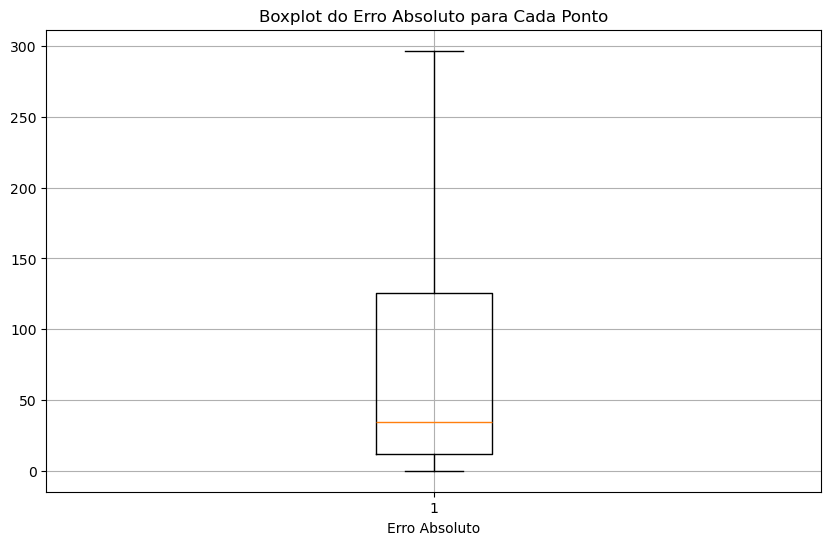

In [15]:
import matplotlib.pyplot as plt

# Calculando o erro absoluto
erro_absoluto_por_ponto = abs(realizado - previsto)

# Criando o boxplot
plt.figure(figsize=(10,6))
plt.boxplot(erro_absoluto_por_ponto, vert=True, showfliers=False)
#plt.ylim(0, 120)
#plt.yticks(np.arange(0, 120, 10))
plt.title('Boxplot do Erro Absoluto para Cada Ponto')
plt.xlabel('Erro Absoluto')
plt.grid(True)
plt.show()
